## Cодержание:
* [Импорт библиотек](#first)
* [Загрузка и изучение данных](#second)
* [Базовый анализ данных](#third)
* [Предобработка данных](#fourth)
* [Обучение модели](#fifth)
* [Тестирование модели](#sixth)
* [Выводы](#seventh)

## Импорт библиотек <a class="anchor" id="first"></a>

In [5]:
import os

import pandas as pd

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from typing import Optional

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import pymorphy2
from sklearn.utils import resample

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier




import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import build_vocab_from_iterator
import torch.nn.functional as F
# TorchText development is stopped and the 0.18 release (April 2024) will be the last stable release of the library.
import torchtext




import time

import re


RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


device(type='cuda', index=0)

## Загрузка данных <a class="anchor" id="second"></a>

Geo Reviews Dataset 2023 - https://github.com/yandex/geo-reviews-dataset-2023


In [6]:
df = pd.read_csv('/kaggle/input/sentimentanalysisyandexreviews/lem_500kdata.csv')

In [7]:
df

,Unnamed: 0,rating,text
0,0,3,московский квартал шумно лето ночь дикий гонка...
1,1,5,замечательный сеть магазин общий хороший ассор...
2,2,1,знать смутить коготь дать правило удивить хоте...
3,3,4,хороший условие аренда дружелюбный персонално ...
4,4,5,топ мастер ангелина топ смысл немного волноват...
...,...,...,...
498824,499994,5,хороший способ избежать автобусный пытка элект...
498825,499995,4,охрана кривая добрый дверь закрываться автомат...
498826,499996,4,сравнение многий современный платформа эпоха с...
498827,499998,5,семья отличный место рекомендовать это настоящ...


## Подготовка данных для обучения модели

### Баланс классов

У нас большой датасет и минорный класс имеет `2` имеет 12071 отзыв, так что я возьму у каждого класса по 50000 отызвов.

In [8]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct


def get_plt_value_counts(Series: pd.Series) -> None:

    value_counts = Series.value_counts()

    plt.figure(figsize=(4, 4))
    plt.pie(value_counts, labels=value_counts.index,
            autopct=make_autopct(value_counts), startangle=30)
    plt.axis('equal')
    plt.title('Распределение отзывов по оценке')

    plt.show()


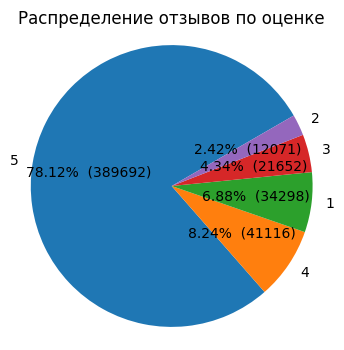

In [9]:
get_plt_value_counts(df['rating'])

In [10]:
def get_balanced_df(df: pd.DataFrame, size) -> pd.DataFrame:
    class_1 = df[df['rating'] == 1]
    class_2 = df[df['rating'] == 2]
    class_3 = df[df['rating'] == 3]
    class_4 = df[df['rating'] == 4]
    class_5 = df[df['rating'] == 5]

    class_1_undersampled = resample(class_1, replace=True, n_samples=size)
    class_2_undersampled = resample(class_2, replace=True, n_samples=size)
    class_3_undersampled = resample(class_3, replace=True, n_samples=size)
    class_4_undersampled = resample(class_4, replace=True, n_samples=size)
    class_5_undersampled = resample(class_5, replace=False, n_samples=size)

    new_df = pd.concat([class_1_undersampled, class_2_undersampled,class_3_undersampled, class_4_undersampled, class_5_undersampled])
    return new_df['text'], new_df['rating']

### Делим выборку на train и test

In [11]:
df['text'] = df['text'].fillna('')
df['rating'] = df['rating'].fillna('')

X = df['text']
y = df['rating']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train_b, y_train_b = get_balanced_df(pd.concat([X_train, y_train], axis=1), 50000)

Делим выборку перед векторизацией, что бы избежать утечки данных при тесте.

### Dataloader

In [19]:
class WordDataset:
    def __init__(self, text, label, token2inx, maxlen=256):
        self.text = text
        self.label = label

        self.token2inx = token2inx
        self.maxlen = maxlen


        self.unk_id = token2inx['<unk>']
        self.pad_id = token2inx['<pad>']

    def __getitem__(self, index):

        processed_text = self.text[index].split()
        tokenized_sentence = [
            self.token2inx.get(word, self.unk_id) for word in processed_text
        ]

        tokenized_sentence = tokenized_sentence[:self.maxlen]

        # Добавление padding, если длина последовательности меньше maxlen
        pad_length = self.maxlen - len(tokenized_sentence)
        tokenized_sentence += [self.pad_id] * pad_length

        train_sample = {"text" : torch.tensor(tokenized_sentence, dtype=torch.long).to(device) ,"label": torch.tensor(self.label[index], dtype=torch.long).to(device)}

        return train_sample

    def __len__(self) -> int:
        return len(self.text)



In [20]:
def yield_tokens(text):
    for line in text:
        yield line.strip().split()

# Disbalanced
vocab = build_vocab_from_iterator(yield_tokens(X_train), specials=["<unk>", "<pad>"])
token2inx = vocab.get_stoi()
inx2token = {inx: token for token, inx in vocab.get_stoi().items()}

# Balanced
vocab_b = build_vocab_from_iterator(yield_tokens(X_train_b), specials=["<unk>", "<pad>"])
token2inx_b = vocab_b.get_stoi()
inx2token_b = {inx: token for token, inx in vocab_b.get_stoi().items()}

In [21]:
len(token2inx), len(token2inx_b)

(400076, 194865)

In [22]:
train_dataset = WordDataset(X_train.values, y_train.values - 1, token2inx)
train_dataset_b = WordDataset(X_train_b.values, y_train_b.values - 1, token2inx_b)

test_dataset = WordDataset(X_test, y_test, token2inx)


train_dataloader = DataLoader(train_dataset,  batch_size=16)
train_dataloader_b = DataLoader(train_dataset_b,  batch_size=16, shuffle=True)


test_dataloader = DataLoader(test_dataset, batch_size=256)

## Обучение моделей <a class="anchor" id="fifth"></a>

### Функции обучения

In [ ]:
def get_confusion_matrix(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
                xticklabels=[1, 2, 3, 4, 5],
                yticklabels=[1, 2, 3, 4, 5])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [24]:
def train_dl(model, optimizer, criterion, n_epochs, train_loader, test_loader):

    loss_train = []
    accuracy_train = []

    for epoch in range(n_epochs):
        model.train()  # для трейна модели ставим ее в train()
        for batch in tqdm(train_loader, desc=f'Training epoch {epoch + 1}:'):
          texts = batch['text']
          labels = batch['label']
          output = model(texts)
          loss = criterion(output, labels)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

        model.eval()  # для теста модели ставим ее в eval()

        correct = 0
        total = 0

        with torch.no_grad():
            for texts, labels in test_loader:

              texts = batch['text']
              labels = batch['label']
              output = model(texts)
              _, predicted = torch.max(output.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

        test_accuracy = correct / total
        accuracy_train.append(test_accuracy)

        print('Epoch [{}/{}], Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(
            epoch + 1, n_epochs, loss.item(), test_accuracy * 100))
        loss_train.append(loss.item())

RNN

In [25]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes = 5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, 128)
        self.projection = nn.Linear(128, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(0.25)


    def forward(self, input_batch):
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        output = output[:, -1, :]  #[batch_size, hidden_dim]

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
vocab_size = len(train_dataloader.dataset.token2inx)
embedding_dim = 150
hidden_size = 64
output_size = 5
n_epochs = 15

rnn_model = RNN(vocab_size, embedding_dim , hidden_size, output_size).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(rnn_model.parameters())

train_dl(rnn_model, optimizer, criterion, n_epochs, train_dataloader, test_dataloader)

Training epoch 1::  27%|██▋       | 6809/24942 [01:22<03:36, 83.83it/s]

Вывод: могу сказать, что тут еще много работать. Есть переобучение. Думаю нужно больше данных и использовать другие методы обучения, которые требуют больших вычислительных затрат. К сожалению, я затянул со сдачей работы и не имею столько времени. Я бы продолжил работу над этим датасетом в в будущем. Лучшая модель - Логистическая регресия в моей случае. Есть сложность в определении 2,3,4 - думаю из-за этого и переобучение. Также есть идея в в лучшей обработке данных, убрать лишнии признаки как я и хотел, что возможно для другой модели дасть лучший результат.

## Проверка отзывов

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))

morph = MorphAnalyzer()


def pr_sentiment(text):
    original_text = text
    text = text.lower()
    text = re.sub(r'[^а-яА-Я ]', '', text)
    text = re.sub('\s+[a-zA-Z]\s+', '', text)
    text = word_tokenize(text, language='russian')
    text = ' '.join(text)

    text = [word for word in text.split() if word not in stop_words]

    lemmatized_words = [morph.parse(word)[0].normal_form for word in text]
    lemmatized_text = " ".join(lemmatized_words)

    review = tfidf_vectorizer.transform([lemmatized_text])
    y_review = logistic_classifier.predict(review)
    print(original_text , y_review)

review = analyze_sentiment("Отличное место")

review = analyze_sentiment("Ужасное место")

review = analyze_sentiment("Неплохое место")

review = analyze_sentiment("Плохое место")

review = analyze_sentiment("Плохое место, но кухня хорошая")

review = analyze_sentiment("Плохое место, но кухня хорошая, офицант нахамил, место грязное")

review = analyze_sentiment("Парк красивый, но очень страшно тут когда темно")

review = analyze_sentiment("Море теплое, отель хороший. Много грязи.")

review = analyze_sentiment("Море теплое, отель не очень. Много грязи. Отель старый, но жить можно.")

review = analyze_sentiment("Море теплое, отель не очень. Много грязи. Отель старый, но жить можно.")